# Parametric Sampling

In this example we show the effectivity in reconstruction of a density volume, optimizating some physical parameters (e.g., environment). Assuming that the unknown physical properties are parameterized as $\phi$, the optimization process alternatively sample matching clouds and then optimize $\phi$. 

$$
\mathcal{L} = \mathbb{E}_{p(x|y;\phi)} \, || y - \mathcal{A}(x;\phi) ||^2
$$

In [1]:
try:  # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install git+https://github.com/rendervous/cloudy_project.git
except:
    print("Executing locally")

Executing locally


Similarly to other tutorials, we will start for imports, load pretrained models, create single view example.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1gtdgT9R4ZpxxC-8Id77N5MSw0j7jops6
To: /home/leonard/rendervous.project/cloudy_project/examples/test/pretrained.zip
100%|██████████| 294M/294M [00:05<00:00, 52.8MB/s] 
/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading cached reference_image.pt


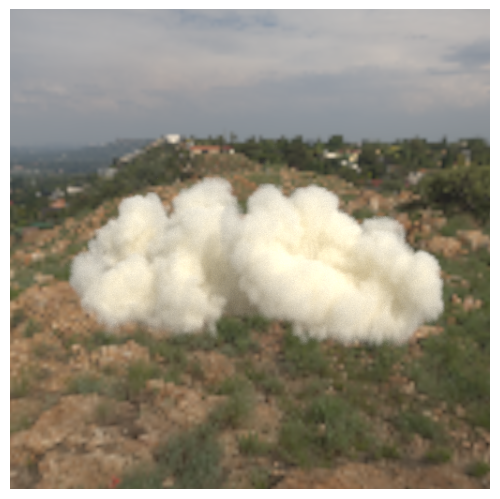

In [2]:
import cloudy
import torch
import numpy as np
import vulky.datasets as datasets  # module containing some resources for examples.
import os
import matplotlib.pyplot as plt


pipeline = cloudy.create_pipeline('./test')
pipeline.download_pretrained()  # Comment if it is already downloaded
recorder = pipeline.create_recorder()
ref_latent = pipeline.get_test_latent(8)
ref_grid = pipeline.decode_latent(ref_latent)
ref_grid = pipeline.clean_volume(ref_grid)

settings = dict(
    camera_position = (np.cos(0.5) * 2.7, np.sin(0.5), np.sin(0.5) * 2.7),
    environment = torch.flip(datasets.Images.environment_example, dims=[0]).contiguous(),  # An HDR environment
    density_scale = 300,
    phase_g = 0.0,
    scattering_albedo = (0.99, 0.98, 0.94),
)

def render_grid(g: torch.Tensor, 
                # These parameters are unknown now
                environment, environment_sampler, 
                samples: int = 128):
    return cloudy.scattered(g * settings['density_scale'],
                     camera_poses=cloudy.camera_poses(settings['camera_position']),
                     scattering_albedo=settings['scattering_albedo'],
                     environment=environment,
                     environment_sampler=environment_sampler,
                     phase_g=settings['phase_g'],
                     majorant=g.max() * settings['density_scale'],
                     # kwargs
                     width=512,  # image width in pixels
                     height=512,  # image height in pixels
                     jittered=True,  # rays pass through 
                     samples=samples,  # number of ray paths for the primal evaluation
                     samples_bw=8,  # number of ray paths for the gradients backprop
                     mode='sps'  # singular path-sampling is used instead of DRT.
                     )


with torch.no_grad():
    # Generate reference image
    if os.path.exists('./reference_image.pt'):
        print("Loading cached reference_image.pt")
        reference_image = torch.load('./reference_image.pt', map_location='cuda', weights_only=True)
    else:
        # create reference image with reference environment
        environment, environment_sampler = cloudy.environment_objects(settings['environment'])
        reference_image = cloudy.accumulate(lambda: render_grid(ref_grid, environment, environment_sampler), times=8)
        torch.save(reference_image, './reference_image.pt')

plt.imshow(reference_image[0].cpu() ** (1.0/2.2))
plt.gca().invert_yaxis()
plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

The function `render_grid` is used as measurement function of the posterior sampling technique, but we need a special function that renders the scene but differentiable with respect to the environment map. Thats the purpose of `scattered_environment`. This function performs a common delta-tracking since that is the optimal path sampler for environment gradients.

The optimization of the environment takes place inside a function in **cloudy** (`reconstruct_volume`) but the parameters and the optimizer is defined outside. In this example we will define an environment map as the sum of two grids. One representing the environment as two colors (sky and earth), the second one is an exponential function over a regular grid with more details ($32\times 64$). This idea forces a smooth regularization de facto.

> Notice that the easier step to an optimizer is to emit the cloud as the environment, therefore, regularization must be used to reduce these ambiguities.

In [3]:
# environment parameters
sun_trainable = torch.nn.Parameter(torch.ones(16, 32, 3, device=pipeline.get_device())*-3.0, requires_grad=True)
sky_estimation = reference_image[0][-30:].mean(dim=0).mean(dim=0)
environment_trainable = torch.nn.Parameter(torch.ones(2, 1, 3, device=pipeline.get_device())*-1.0, requires_grad=True)
with torch.no_grad():
    environment_trainable[1, 0] = torch.log(sky_estimation / (1 - sky_estimation))

# environment map model
def compute_environment_map():
    sky = cloudy.resampling(torch.sigmoid(environment_trainable).unsqueeze(0), (16, 32), mode='nearest-exact', align_corners=None)[0].contiguous()
    sun = torch.exp(sun_trainable)
    return sun + sky

The method for the reconstruction of physical parameters is `reconstruct_volume`. The difference with `sample_volume` is that it performs several passes and therefore, instead of a single measurement function, a factory is provided. This way the posterior sampling could change during the whole process, e.g., using coarser volume in first passes or changing the `guiding_strength` among the passes.

In [4]:
def create_A(samples: int = 64):
    with torch.no_grad():
        # assume current environment map fixed during DPS
        environment_tensor = compute_environment_map()
    environment, environment_sampler = cloudy.environment_objects(environment_tensor)
    return lambda g: render_grid(g, environment, environment_sampler, samples=samples)

Although the gradients for the guiding during posterior sampling responds to a gaussian noise and at the end an L2 loss, the loss for the physical parameters optimization can be any and could (more likely) include a regularization term.

In [5]:
def create_L(g: torch.Tensor, y: torch.Tensor, samples: int = 64):
    def L():
        yhat = cloudy.scattered_environment(
             environment=compute_environment_map(),
             grid=g * settings['density_scale'],
             camera_poses=cloudy.camera_poses(settings['camera_position']),
             majorant=g.max().item() * settings['density_scale'],
             scattering_albedo=settings['scattering_albedo'],
             phase_g=settings['phase_g'],
             width=512,
             height=512,
             jittered=True,
             samples=samples,
             bw_samples=max(1, samples // 8),
             )
        loss = torch.nn.functional.mse_loss(yhat, y, reduction='sum')
        sun = torch.exp(sun_trainable)
        loss += 0.001 * cloudy.total_variation_2D(sun.unsqueeze(0))
        loss += 0.001 * sun.abs().sum()
        return loss
    return L

In [6]:
# create optimizer
opt = torch.optim.NAdam([sun_trainable, environment_trainable], lr=0.01)

In [7]:
grid = pipeline.reconstruct_volume(
    y = reference_image,
    A_factory = lambda p: create_A(),
    L_factory = lambda p, grid, y: create_L(grid, y),  # no physical parameter unknown
    optimizer=opt,
    resolution=128,
    ema_factor=0.2,
    samples=100,
    scheduler_gamma=.6,
    weights=[0.2, 0.4, 0.6, 0.8, 1.0],
    decoding_resolution=[32, 32, 64, 64, 128],
    decoding_noise=[1.0, 1.0, 1.0, 1.0, 0.0],
    optimization_steps=200,
    optimization_passes=5,
)


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Posterior sampling DPS_DDIM: 100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


Let's capture different camera poses...

Rendering captures:   0%|          | 0/8 [00:00<?, ?it/s]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  12%|█▎        | 1/8 [00:01<00:10,  1.51s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  25%|██▌       | 2/8 [00:02<00:07,  1.23s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  38%|███▊      | 3/8 [00:03<00:05,  1.10s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  50%|█████     | 4/8 [00:04<00:04,  1.08s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  62%|██████▎   | 5/8 [00:05<00:03,  1.01s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  75%|███████▌  | 6/8 [00:06<00:02,  1.04s/it]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  88%|████████▊ | 7/8 [00:07<00:00,  1.02it/s]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


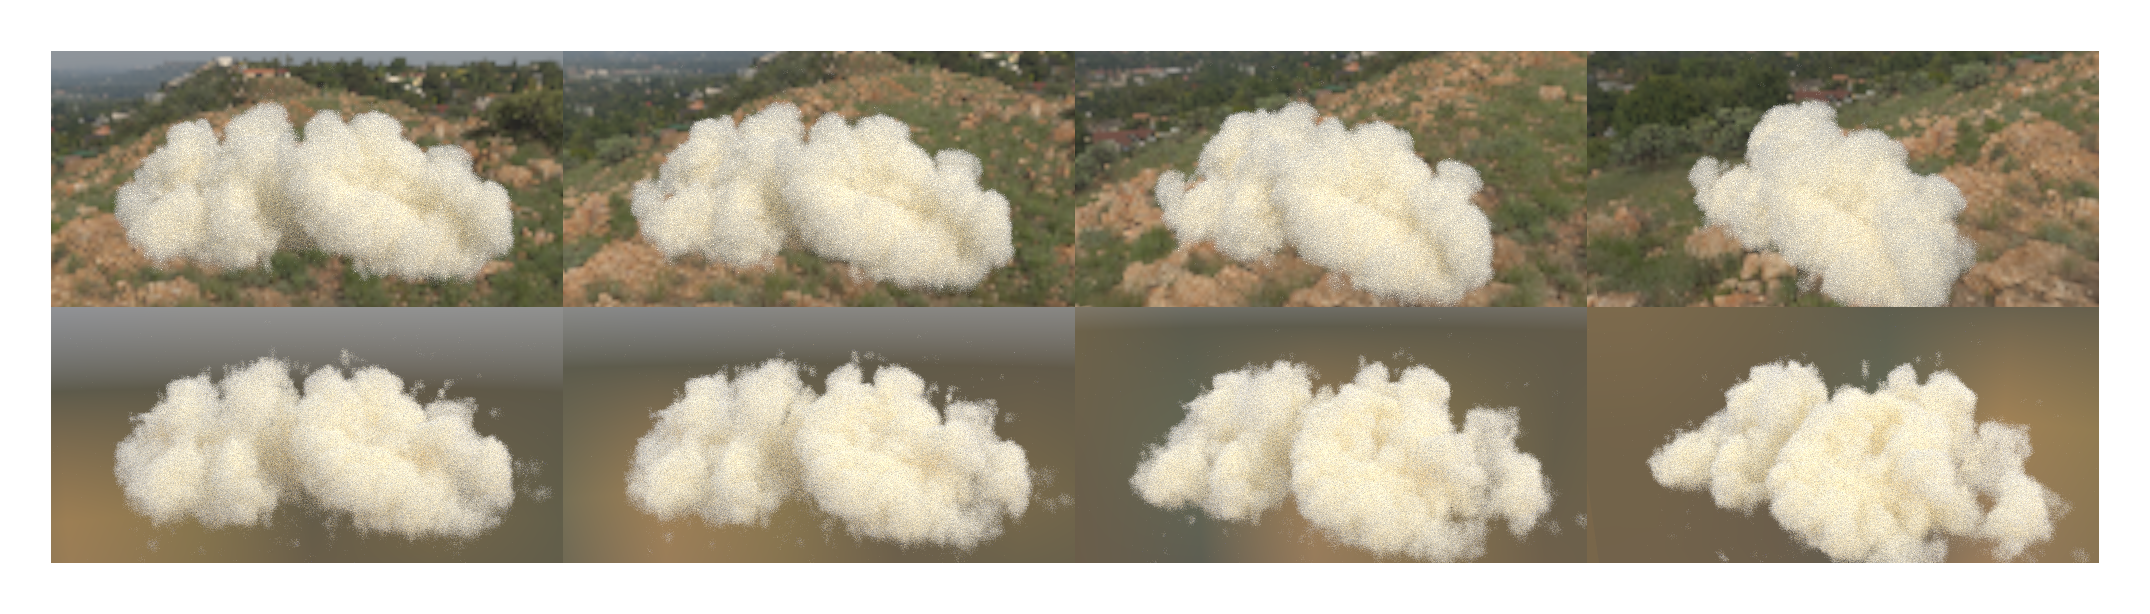

In [8]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# saves the grid in the recorder to be used several times
ref_grid_id = recorder.add_volume(ref_grid)
grid_id = recorder.add_volume(grid)
# saves the environment tensor
ref_env_id = recorder.add_environment(settings['environment'])
with torch.no_grad():
    env_id = recorder.add_environment(compute_environment_map())
# capture multiple camera poses
for i in range(4):
    alpha = (i/4)**1.5
    recorder.new_keyframe(
        # Novel view for the reference grid
        recorder.add_capture_volume(ref_grid_id,
                                    environment=ref_env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms'),
        # Novel view for the sampled grid
        recorder.add_capture_volume(grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, np.sin(0.5 + alpha), np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=32, render_mode='ms')        
    )
recorder.show_clip(4)

Showing the reconstructed volume

Rendering captures:   0%|          | 0/2 [00:00<?, ?it/s]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s]
Accumulating:: 0it [00:00, ?it/s]
Rendering captures: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


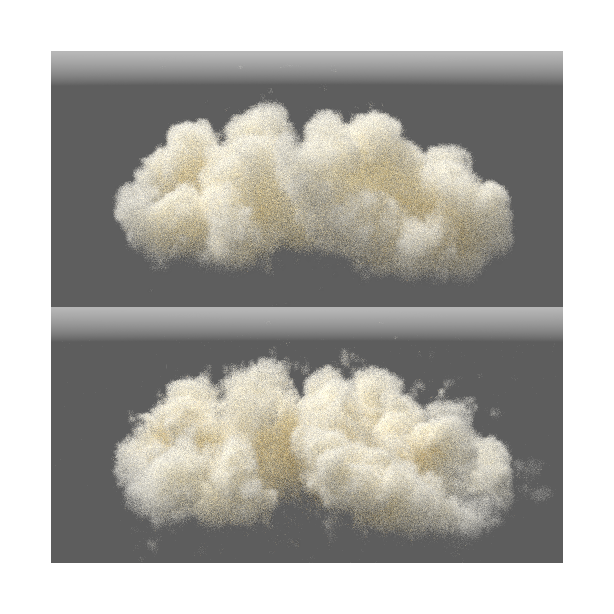

In [9]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# capture multiple camera poses
recorder.new_keyframe(
    # Novel view for the reference grid
    recorder.add_capture_volume(ref_grid,
                                # default environment used
                                camera_position=settings['camera_position'],
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms'),
    # Novel view for the sampled grid
    recorder.add_capture_volume(grid,
                                # default environment used
                                camera_position=settings['camera_position'],
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=32, render_mode='ms')        
)
recorder.show_clip(1)